In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


# NN-SPM Training on Sensor Data
The sensor data is provided by NAPA for a ferry sailing on shallow waters.

We were provided two files. The first file, `sensor_data_full.csv` contains more data points but, according to Roberto, has some inconsistent draft and depth (etc.) values, the fuel mass flow is including so called Hotel Costs (energy for fuel and cargo onboard), and the data also contains points where the ship was in harbour and not moving.

In the dataset `sensor_data_filtered_20230508.csv` the mentioned inconsistencies are removed and the fuel mass flow is only considering the required fuel for propulsion. The file has ca. 40 000 rows.

In the following we will only consider the filtered dataset.

# TODO: setup MLflow exp. logging

In [2]:
file = 'sensor_data/sensors_data_filtered_20230508.csv'

df = pd.read_csv(file)
df.head(5)

,draft,speedOverGround,courseOverGround,fuelMassFlow,windSpeed,windDirection,windWavesSignificantHeight,windWavesZeroCrossingPeriod,windWavesDirection,swellSignificantHeight,swellZeroCrossingPeriod,swellDirection,currentSpeed,currentDirection,waterDepth
0,5.901807,5.157308,211.389999,0.202109,8.044598,250.359271,0.604218,3.052564,245.339647,0.125000,3.879783,241.248730,0.060868,149.966453,13.59750
1,5.887334,5.129390,212.743903,0.202227,8.069089,250.154624,0.609470,3.052958,245.380179,0.123610,3.902562,239.113185,0.061043,153.253748,13.25122
2,5.886533,5.134158,212.157501,0.201974,8.097059,249.965965,0.617564,3.053715,245.520500,0.121978,3.925689,236.333132,0.061794,157.068520,13.00750
3,5.884516,5.129014,211.647500,0.203896,8.129371,249.795188,0.623060,3.053963,245.595967,0.122784,3.925000,234.743811,0.061222,159.910039,12.78250
4,5.887981,5.153450,211.572500,0.203379,8.166148,249.639649,0.624373,3.057707,245.615459,0.125479,3.914312,233.971958,0.060738,161.038265,12.73000


The following table shows a summarization for every column of the dataset.

In [3]:
df.describe()

,draft,speedOverGround,courseOverGround,fuelMassFlow,windSpeed,windDirection,windWavesSignificantHeight,windWavesZeroCrossingPeriod,windWavesDirection,swellSignificantHeight,swellZeroCrossingPeriod,swellDirection,currentSpeed,currentDirection,waterDepth
count,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000
mean,6.020380,7.369780,138.233535,0.502078,7.111252,204.032677,0.541836,2.509293,203.681837,0.183754,3.311611,171.771946,0.089168,170.427415,17.828402
std,0.554666,1.907991,96.441083,0.227583,3.393846,84.483235,0.496363,1.177409,84.268877,0.138122,1.203116,96.209145,0.072560,101.022166,7.537917
min,3.052449,0.000000,0.008330,0.000000,0.051508,0.017409,0.000000,0.000000,0.002858,0.000000,0.000000,0.000000,0.000218,0.035442,4.050000
25%,5.753898,6.892273,37.260206,0.365111,4.501013,143.790268,0.166885,1.787614,143.861548,0.093139,2.543889,72.520794,0.038362,73.881822,13.137500
50%,5.994312,7.571340,185.534328,0.469684,6.818493,219.793354,0.442754,2.571628,220.830102,0.147583,3.290000,195.100351,0.070211,166.135213,16.905000
75%,6.208308,8.658104,216.117496,0.747067,9.362980,268.150664,0.809500,3.326778,265.641971,0.243111,4.044972,246.766077,0.118163,256.389211,21.512820
max,9.697656,10.172814,359.897932,1.021509,22.220428,359.979302,4.910757,7.615618,360.000000,1.292560,9.593130,360.000000,0.637598,359.995485,93.615383


## Hyperparameter and Model Setup

In [21]:
N_EPOCHS = 200    
LEARNING_RATE = 0.005
BATCH_SIZE = 64
REPORT_EVERY = 1
input_n = 14
output_n = 1
HIDDEN_SIZE = 10

Following the model architecture:
It has 10 fully connected layers:
- input layer with 14 inputs
- 8 hidden layers with `HIDDEN_SIZE` neurons
- output layer with 1 output for the fuel mass flow estimation

**TODO**:
Check how this is supposed to be done.
looks a little messy here and hard to see on first glance how the forward function is working.

In [5]:
class fnn(torch.nn.Module):
    def __init__(self, input_dim, out_dim, hidden_size):
        super().__init__()
        self.inputs = input_dim
        self.outputs = out_dim
        self.hidden = hidden_size
        
        # layers
        self.fc1 = torch.nn.Linear(self.inputs, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc5 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc6 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc7 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc8 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc9 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc10 = torch.nn.Linear(hidden_size, self.outputs)
        self.bn = torch.nn.BatchNorm1d(hidden_size)

        
        # activation
        self.lrelu = torch.nn.LeakyReLU(0.2)
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.elu = torch.nn.ELU()
        self.sigmoid= torch.nn.Sigmoid()
        self.logsigmoid= torch.nn.LogSigmoid()
        
        # initialize the weights
        self.init_weights()
        
    def init_weights(self):
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        torch.nn.init.kaiming_normal_(self.fc4.weight)
        torch.nn.init.kaiming_normal_(self.fc5.weight)
        torch.nn.init.kaiming_normal_(self.fc6.weight)
        torch.nn.init.kaiming_normal_(self.fc7.weight)
        torch.nn.init.kaiming_normal_(self.fc8.weight)
        torch.nn.init.kaiming_normal_(self.fc9.weight)
        torch.nn.init.kaiming_normal_(self.fc10.weight)


        
    def forward(self, features):
        output = self.fc1(features)
        output = self.lrelu(output)  
        output = self.fc2(output)
        output = self.lrelu(output)
        output = self.fc3(output)
        output = self.lrelu(output)
        output = self.fc4(output)
        output = self.lrelu(output)
        output = self.fc5(output)
        output = self.lrelu(output)       
        output = self.fc6(output)
        output = self.lrelu(output)
        output = self.fc7(output)
        output = self.lrelu(output)
        output = self.fc8(output)
        output = self.lrelu(output)
        output = self.fc9(output)

        output = self.lrelu(output)
        output = self.fc10(output)
        return output


In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [7]:
model = fnn(input_dim = input_n, out_dim = output_n, hidden_size = HIDDEN_SIZE).to(device)
model

fnn(
  (fc1): Linear(in_features=14, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=10, bias=True)
  (fc7): Linear(in_features=10, out_features=10, bias=True)
  (fc8): Linear(in_features=10, out_features=10, bias=True)
  (fc9): Linear(in_features=10, out_features=10, bias=True)
  (fc10): Linear(in_features=10, out_features=1, bias=True)
  (bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (relu): ReLU()
  (tanh): Tanh()
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
  (logsigmoid): LogSigmoid()
)

Setting the loss function and optimizer

In [9]:
loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.L1Loss()

optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(params = model.parameters(), lr=LEARNING_RATE, momentum = 0.9)

## Preparing Test and Validation Sets
Next we split the dataframe into train and validation data with a ratio of 80%.
Here the split is only into training and validation sets.

Later when the hyperparameters have been tuned the data is dividied into train, test and validation.

> I currently don't know why this is done like this.

First, we make sure that the `fuel mass flow` column is at the end of the dataframe.

In [10]:
fmf = df.pop('fuelMassFlow')
df.insert(len(df.columns), 'fuelMassFlow', value=fmf)

In [11]:
seed = 20
split = 0.8

train_df=df.sample(frac=split,random_state=seed)
val_df=df.drop(train_df.index)
print(train_df.shape)
print(val_df.shape)

(32820, 15)
(8205, 15)


In [12]:
# For this part, making sure that FuelMassFlow is stored in the 15th column in the csv. 
# Otherwise change the number '14' and ':14' accordingly
class dds(Dataset):
    def __init__(self, df):
        x = df.iloc[:, :14].values
        y = df.iloc[:, 14].values    

        self.x_tensor = torch.tensor(x, dtype = torch.float32)
        self.y_tensor = torch.tensor(y, dtype = torch.float32).reshape(-1,1)

    def __len__(self):
        return len(self.y_tensor)

    def __getitem__(self,idx):
        return self.x_tensor[idx], self.y_tensor[idx]

In [13]:
train_ds = dds(train_df)
val_ds = dds(val_df)

train_loader = DataLoader(dataset = train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset = val_ds, batch_size = val_df.shape[0], shuffle = False)


# Training

In [18]:
val_points = np.zeros((val_df.shape[0],2,N_EPOCHS//REPORT_EVERY))
loss_train_val = np.zeros((N_EPOCHS//REPORT_EVERY,2))
for epoch in range(N_EPOCHS):
    
    model.train()
    loss_epoch_train = 0
    for features, targets in train_loader:
        # forward propagation
        output = model(features)
        loss = loss_fn(output, targets)
        #initialize the gradient to zero
        optimizer.zero_grad()
        #back propagation
        loss.backward()
        #update the weights
        optimizer.step()
        
        loss_epoch_train+= targets.shape[0]*loss.item()
    
    
    model.eval() # stop training:

    # predict validation set:
    for feature_val, target_val in val_loader:
        prediction_val = model(feature_val)
        mse_val = loss_fn(prediction_val, target_val)
   
    # early stop can be added
    # If needed, record the model with the best accuracy

    
    if (epoch+1)%REPORT_EVERY == 0:   
       
        mse_epoch_train = loss_epoch_train/train_df.shape[0]
        print('Epoch {}/{}:'.format(epoch+1, N_EPOCHS))
        print('loss_train: {:4f}'.format(mse_epoch_train))
        print('loss_valid: {:4f}'.format(mse_val.item()))
        val_points[:, 0, (epoch+1)//REPORT_EVERY-1] = target_val[:,0].detach().numpy()
        val_points[:, 1, (epoch+1)//REPORT_EVERY-1] = prediction_val[:,0].detach().numpy()
        loss_train_val[int((epoch+1)/REPORT_EVERY)-1, 0] = np.round(mse_epoch_train, 4)
        loss_train_val[int((epoch+1)/REPORT_EVERY)-1, 1] = np.round(mse_val.item(), 4)

    

Epoch 1/200:
loss_train: 117.581275
loss_valid: 0.180359
Epoch 2/200:
loss_train: 0.343330
loss_valid: 0.169638
Epoch 3/200:
loss_train: 1.250102
loss_valid: 0.088564
Epoch 4/200:
loss_train: 0.180510
loss_valid: 0.356127
Epoch 5/200:
loss_train: 0.362042
loss_valid: 0.082582
Epoch 6/200:
loss_train: 0.329622
loss_valid: 1.082974
Epoch 7/200:
loss_train: 0.189931
loss_valid: 0.313974
Epoch 8/200:
loss_train: 0.210456
loss_valid: 0.071824
Epoch 9/200:
loss_train: 0.181066
loss_valid: 0.275033
Epoch 10/200:
loss_train: 0.158745
loss_valid: 0.109347
Epoch 11/200:
loss_train: 0.107654
loss_valid: 0.054664
Epoch 12/200:
loss_train: 0.118852
loss_valid: 0.076084
Epoch 13/200:
loss_train: 0.100515
loss_valid: 0.244743
Epoch 14/200:
loss_train: 0.073496
loss_valid: 0.053689
Epoch 15/200:
loss_train: 0.075142
loss_valid: 0.050889
Epoch 16/200:
loss_train: 0.076426
loss_valid: 0.055918
Epoch 17/200:
loss_train: 0.064434
loss_valid: 0.068963
Epoch 18/200:
loss_train: 0.063223
loss_valid: 0.057723

Runtime for 200 epochs: ~9 min

## Results
Plotting the train and validation loss

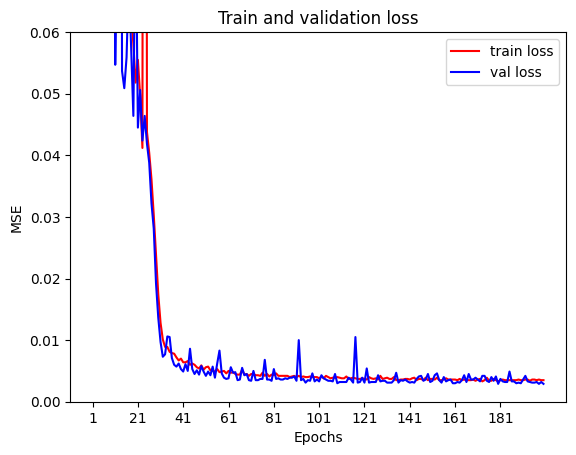

In [23]:
e = np.arange(1, N_EPOCHS+1, REPORT_EVERY, dtype = int)
plt.plot(e, loss_train_val[:,0], c = 'r', label = 'train loss')
plt.plot(e, loss_train_val[:,1], c = 'b', label = 'val loss')
plt.xticks(np.arange(min(e), max(e)+1, 20))
plt.ylim(0, 0.06)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Train and validation loss')
plt.show()

Lastly this stores the trained model to a pytorch file.

**TODO**: setup automatic storing/logging to MLflow for this.

In [15]:
# save as pre-trained model
state = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(state, 'pre_trained_save.pt')